In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pandas as pd
from pathlib import Path
from evaluation.cross_tool_analysis import (
    load_proverbot,
    load_tactician,
    load_human,
    load_rango,
    get_unique_files,
    get_mutual_proof_pairs,
    NamedEval,
    get_two_eval_subsets,
    SuccessfulResult,
    GeneralResult,
    get_mutually_successful_proof_pairs,
    proof_length,
)

In [2]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling":
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")

In [3]:
PROVERBOT_LOC = Path("evaluations/proverbot")
TACTICIAN_LOC = Path("evaluations/tactician/results-24-07-22")
GRAPH2TAC_LOC = Path("evaluations/graph2tac/results-2024-07-29")
RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-prem-final")
HUMAN_LOC = Path("evaluations/human")
# RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-prem-final-test-500")
# RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-final-test-500")

In [4]:
proverbot_eval = NamedEval("proverbot", load_proverbot(PROVERBOT_LOC))
tactician_eval = NamedEval("tactician", load_tactician(TACTICIAN_LOC))
graph2tac_eval = NamedEval("graph2tac", load_tactician(GRAPH2TAC_LOC))
human_eval = NamedEval("human", load_human(HUMAN_LOC))
rango_eval = NamedEval("rango", load_rango(RANGO_LOC))

In [5]:
# rango_eval = NamedEval("rango", load_rango(RANGO_LOC))

In [6]:
raw_evals = [
    rango_eval,
    tactician_eval,
    human_eval,
    # proverbot_eval,
    # graph2tac_eval,
]

In [7]:
[len(e.results) for e in raw_evals]

[9631, 10714, 12077]

In [8]:
mutual_proofs = get_mutual_proof_pairs(raw_evals)
evals = [e.filter_results(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)

## Proof Rates by Ground Truth Length

In [32]:
ranges = [
    (1, 4),
    (5, 8),
    (9, 12),
    (13, 16),
    (17, 20),
    (21, None),
]

range_sets = [human_eval.get_successful_proofs_in_range(*r) for r in ranges]
mutual_range_stes = [mutual_proofs & r for r in range_sets]
rows: list[list[float]] = []
for range_set in mutual_range_stes:
    row: list[float] = []
    for eval in evals:
        range_results = eval.filter_results(range_set)
        successes = len(range_results.get_successful_results())
        attempts = len(range_results.results)
        row.append(successes / attempts)
    rows.append(row)
df = pd.DataFrame(rows, columns=[e.name for e in evals], index=[f"{r[0]}-{r[1]}" for r in ranges])
df



,rango,tactician,human
1-4,0.519768,0.442399,1.0
5-8,0.304302,0.295908,1.0
9-12,0.130693,0.120792,1.0
13-16,0.066890,0.085284,1.0
17-20,0.035011,0.054705,1.0
21-None,0.010892,0.014976,1.0


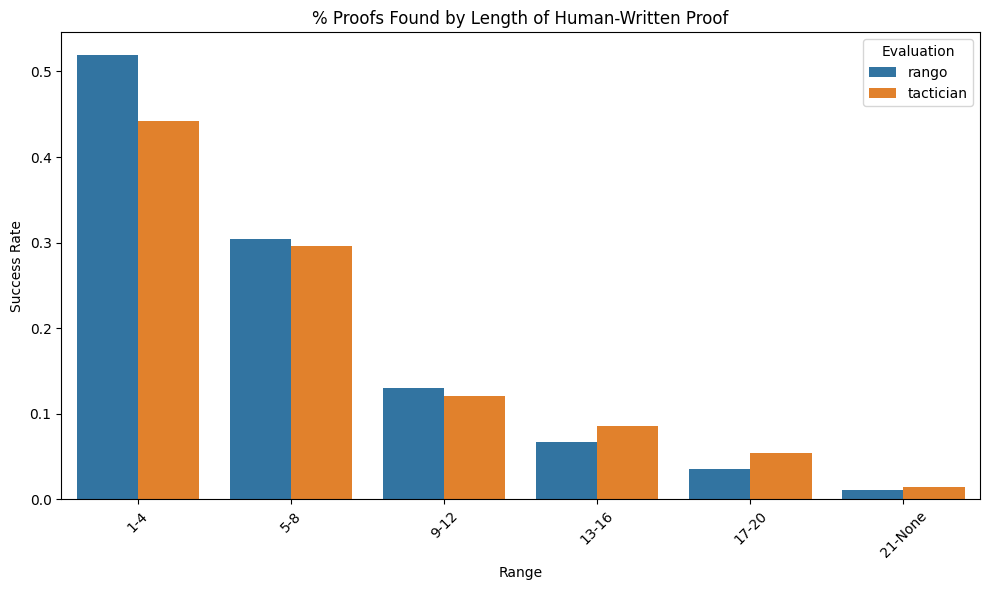

In [34]:
if "human" in df.columns:
    df = df.drop(columns=["human"])
#df.plot(kind="bar", figsize=(10, 5))

# Reset the index to use it as a column for Seaborn
plot_df = df.reset_index().melt(id_vars=['index'], var_name='Evaluation', value_name='Success Rate')

# Rename the 'index' column to 'Range'
plot_df = plot_df.rename(columns={'index': 'Range'})

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Range', y='Success Rate', hue='Evaluation', data=plot_df)
plt.xlabel('Range')
plt.ylabel('% Proofs Found')
plt.title('% Proofs Found by Length of Human-Written Proof')
plt.xticks(rotation=45)
plt.legend(title='System')
plt.tight_layout()
plt.show()

## Overall Results

In [10]:
[len(e.results) for e in evals]

[8286, 8286, 8286]

In [11]:
def attempts_by_project(e: NamedEval) -> dict[str, list[GeneralResult]]:
    grouped_results: dict[str, list[GeneralResult]] = {}
    for r in e.results:
        project = r.file.parts[0]
        if project not in grouped_results:
            grouped_results[project] = []
        grouped_results[project].append(r)
    return grouped_results


def count_successes(results: list[GeneralResult]) -> int:
    return sum(1 for r in results if r.success)


rows: list[tuple[str, str, int, int, float, str]] = []
for e in raw_evals:
    attempts_by_proj = attempts_by_project(e)
    for proj, attempts in attempts_by_project(e).items():
        n_successes = count_successes(attempts)
        n_attempts = len(attempts)
        p = n_successes / n_attempts
        p_str = f"{p:.3f} ({n_successes}/{n_attempts})"
        rows.append((e.name, proj, n_successes, n_attempts, p, p_str))
total_df = pd.DataFrame(
    rows,
    columns=[
        "System",
        "Project",
        "Successes",
        "Attempts",
        "Success Rate [f]",
        "Success Rate",
    ],
)
total_df.groupby("System").agg({"Successes": "sum", "Attempts": "sum"}).assign(
    SuccessRate=lambda df: df["Successes"] / df["Attempts"]
)

,Successes,Attempts,SuccessRate
System,,,
human,12077,12077,1.000000
rango,2839,9631,0.294777
tactician,2742,10714,0.255927


In [12]:
system_cols = total_df.set_index(["Project", "System"])["Success Rate"].unstack()
system_cols.loc[~pd.isna(system_cols["tactician"])]

System,human,rango,tactician
Project,,,
CompCert,1.000 (6477/6477),0.283 (1475/5212),0.244 (1302/5330)
PolTac,1.000 (309/309),0.789 (195/247),0.854 (264/309)
buchberger,1.000 (658/658),0.217 (116/535),0.226 (149/658)
coq-ext-lib,1.000 (227/227),0.514 (91/177),0.581 (132/227)
dblib,1.000 (203/203),0.548 (86/157),0.473 (96/203)
fourcolor,1.000 (1496/1496),0.156 (179/1151),0.047 (70/1494)
hoare-tut,1.000 (9/9),0.167 (1/6),0.222 (2/9)
huffman,1.000 (270/270),0.237 (51/215),0.215 (58/270)
math-classes,1.000 (1501/1501),0.329 (398/1210),0.341 (512/1501)


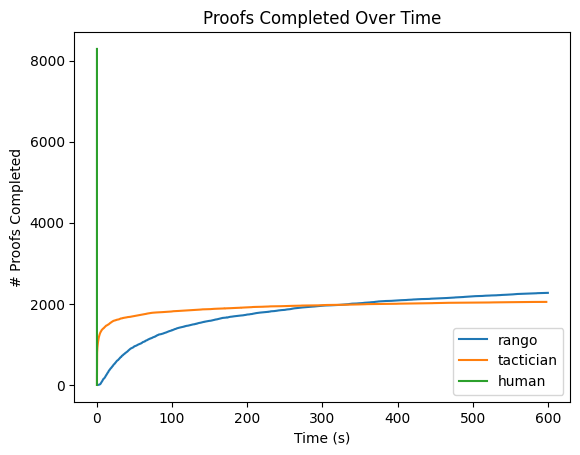

In [13]:
def plot_times(es: list[NamedEval]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.name)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

Total # Found =  2850


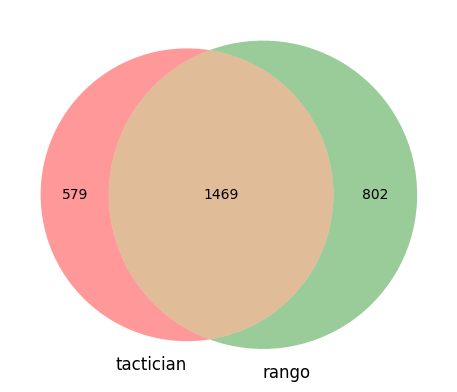

In [14]:
def compare_two(es: list[NamedEval], e1_alias: str, e2_alias: str) -> int:
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2(
        (len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
        set_labels=(e1_alias, e2_alias),
        ax=ax,
    )
    get_two_eval_subsets(es, e1_alias, e2_alias)
    return len(subsets.one_only) + len(subsets.one_two) + len(subsets.two_only)


total_found = compare_two(evals, "tactician", "rango")
print("Total # Found = ", total_found)

In [15]:
subsets = get_two_eval_subsets(evals, "tactician", "rango")

In [16]:
import json

with open("tactician_only.json", "w") as fout:
    fout.write(
        json.dumps(
            [{"file": str(s.file), "theorem": s.theorem} for s in subsets.one_only],
            indent=2,
        )
    )

## Proof Length & Similarity

In [17]:
successes = get_mutually_successful_proof_pairs(raw_evals)
print("Mutually successful: ", len(successes["rango"]))

Mutually successful:  1503


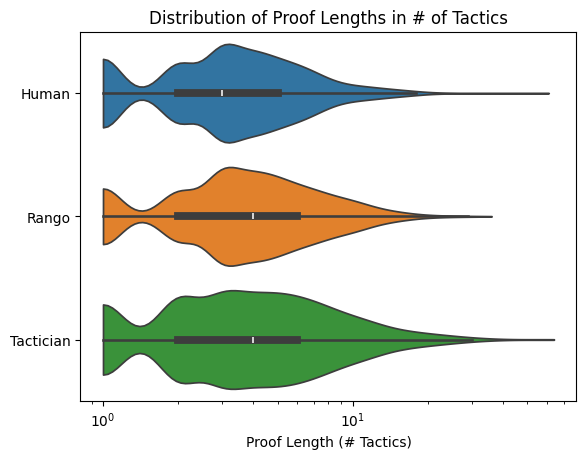

In [18]:
import seaborn as sns


keys = ["human", "rango", "tactician"]
proof_lengths = pd.DataFrame(
    dict([(k.title(), [proof_length(s.proof) for s in successes[k]]) for k in keys])
)
proof_lengths.to_csv("proof-length-df.csv")
fig, ax = plt.subplots()
sns.violinplot(
    proof_lengths,
    orient="h",
    ax=ax,
    log_scale=True,
    cut=0,
)
ax.set_title("Distribution of Proof Lengths in # of Tactics")
ax.set_xlabel("Proof Length (# Tactics)")
fig.savefig("proof-length-violin.png")

In [19]:
proof_lengths.mean()

Human        3.881570
Rango        4.437126
Tactician    5.047904
dtype: float64

In [20]:
proof_lengths.median()

Human        3.0
Rango        4.0
Tactician    4.0
dtype: float64

In [21]:
short_tactician_pairs = [
    (p.proof, h.proof)
    for p, h in zip(successes["tactician"], successes["human"])
    if proof_length(p.proof) < proof_length(h.proof)
]
import random

random.seed(0)
short_tactician_sample = random.sample(short_tactician_pairs, 100)
for s, h in short_tactician_sample:
    print("Tactician: ", (proof_length(s)))
    print(s)
    print()
    print("Human: ", (proof_length(h)))
    print(h)
    print("===========================")

Tactician:  2
intros; reflexivity

Human:  3

Proof.
  intros; destruct chunk; reflexivity.
Qed.
Tactician:  2
intros x n Hd; auto with ints

Human:  4

Proof.
  intros. apply eqm_trans with b. auto.
  apply eqm_unsigned_repr.
Qed.
Tactician:  7
intros a; apply Fix_eq with (P := fun x : A => B); intros; assert (f = g); eauto using @FunctionalExtensionality.functional_extensionality_dep; subst g; auto

Human:  12

Proof.
  unfold Fixm; intros. apply Wf.Fix_eq with (P := fun (x: A) => B).
  intros. assert (f = g). apply functional_extensionality_dep; intros.
  apply functional_extensionality; intros. auto.
  subst g; auto.
Qed.
Tactician:  1
discriminate

Human:  4

Proof.
  unfold agree32, Ptrofs.add, Int.add; intros. rewrite H, H0. apply agree32_repr.
Qed.
Tactician:  2
intros; apply repr_unsigned

Human:  6

Proof.
  bit_solve. rewrite unsigned_zero. rewrite zlt_true. f_equal; lia. lia.
Qed.
Tactician:  2
repeat (split; try apply _)

Human:  4

Proof.
  repeat split; repeat (try apply

In [22]:
human_proofs = [s.proof for s in successes["human"]]
rango_proofs = [s.proof for s in successes["rango"]]
tactician_proofs = [s.proof for s in successes["tactician"]]
rango_edists = [
    fair_edist(human_proof, s.proof)
    for s, human_proof in zip(successes["rango"], human_proofs)
]
tactician_edists = [
    fair_edist(human_proof, s.proof)
    for s, human_proof in zip(successes["tactician"], human_proofs)
]
edist_df = pd.DataFrame(dict(rango=rango_edists, tactician=tactician_edists))
edist_df["rango"] = edist_df["rango"].astype(float)
edist_df["tactician"] = edist_df["tactician"].astype(float)
fig, ax = plt.subplots()
sns.violinplot(edist_df, orient="h", ax=ax)

NameError: name 'fair_edist' is not defined

In [ ]:
edist_df.mean()

rango        33.526667
tactician    56.067333
dtype: float64

In [ ]:
edist_df.median()

rango        22.0
tactician    38.0
dtype: float64